# Workflow to create a MESSAGE Scenario using d2ix

In [1]:
import pandas as pd
from d2ix import Model
from d2ix import PostProcess
from d2ix import ModifyModel

In [2]:
model = Model(model='MESSAGE_Indonesia', scen='Indonesia baseline',
              annotation='Indonesia model',
              base_xls='input/modell_data.xlsx',
              manual_parameter_xls='input/manual_input_parameter.xlsx',
              historical_data=True, historical_range_year=1,
              first_historical_year=2000, model_range_year=5,
              first_model_year=2020, last_model_year=2030,
              run_config='config/run_config.yml',
              verbose=False, yaml_export=False)

2018-10-19 13:04:38,281  INFO d2ix.core - Load data base configurations
2018-10-19 13:04:38,395  INFO root - launching ixmp.Platform with local HSQLDB database at 'C:\Users\ga46gup\.local\ixmp\localdb\default'
2018-10-19 13:04:42,646  INFO d2ix.core - Load model input data from: 'input/modell_data.xlsx'
2018-10-19 13:04:42,707  INFO d2ix.core - Load model input data from: 'input/manual_input_parameter.xlsx'
2018-10-19 13:04:42,794  INFO d2ix.core - Create parameters from: 'input/modell_data.xlsx'
2018-10-19 13:04:43,640  INFO d2ix.core - Create demands from: 'input/modell_data.xlsx'
2018-10-19 13:04:43,699  INFO d2ix.core - Create parameters from: 'input/manual_input_parameter.xlsx'
2018-10-19 13:04:43,700  INFO d2ix.core - Create parameters from: 'input/modell_data.xlsx' - 'rel_and_flex'
2018-10-19 13:04:43,738  INFO d2ix.core - Create parameters from: 'input/modell_data.xlsx' - 'renewable_potential'
2018-10-19 13:04:43,742  INFO d2ix.core - Create sets from: 'input/modell_data.xlsx' 

In [3]:
hist_new_cap = model.get_parameter(par='historical_new_capacity')
for par in ['input', 'output']:
    df = model.get_parameter(par=par)
    _model_input = df[df.year_vtg >= 2020].copy()
    _hist_input = df[df.year_vtg < 2020].copy()
    _hist_input = _hist_input.merge(hist_new_cap, how='inner',
                                    on=['technology', 'node_loc',
                                        'year_vtg'], suffixes=['', 'y'])

    df = pd.concat([_model_input, _hist_input[_model_input.columns]]
                   ).reset_index(drop=True)
    model.set_parameter(par=df, name=par)

In [4]:
# Example on how to access and edit parameters manually if neccessary
demand = model.get_parameter(par='demand')
list(set(demand.commodity))
demand.head()

,node,commodity,level,year,time,value,unit
0,Indonesia,electricity,useful,2020,year,50.0,GWa
1,Indonesia,electricity,useful,2025,year,80.0,GWa
2,Indonesia,electricity,useful,2030,year,100.0,GWa


In [5]:
# To test the slack technologies we now add a demand that we do not have yet added a technology
demand.loc[:,'value'] = demand.loc[:,'value'].copy() *1.5
demand.head()

,node,commodity,level,year,time,value,unit
0,Indonesia,electricity,useful,2020,year,75.0,GWa
1,Indonesia,electricity,useful,2025,year,120.0,GWa
2,Indonesia,electricity,useful,2030,year,150.0,GWa


In [6]:
model.set_parameter(par=demand, name='demand')

In [7]:
scenario = model.model2db()
scenario.solve(model='MESSAGE')

2018-10-19 13:04:43,973  INFO d2ix.core - Prepare model input data
2018-10-19 13:04:44,031  INFO d2ix.core - Unit check
2018-10-19 13:04:44,043  INFO d2ix.core - Add sets to scenario
2018-10-19 13:04:44,055  INFO d2ix.core - Add parameter to scenario


# Postprocessing Workflow

In [8]:
# Create timeseries from scenario results in preperation to post processing
model.create_timeseries(scenario)
model.close_db()

2018-10-19 13:04:46,760  INFO d2ix.postprocess.timeseries - Create timeseries


In [9]:
# Crate an instance of the d2ix post process class:
# Post process for a specific scenario: model, scen, version
pp = PostProcess(run_config='config/run_config_notebook.yml', 
                 model='MESSAGE_Indonesia', scen='Indonesia baseline', version=None)

2018-10-19 13:04:47,582  INFO d2ix.core - Load data base configurations
2018-10-19 13:04:47,583  INFO root - launching ixmp.Platform with local HSQLDB database at 'C:\Users\ga46gup\.local\ixmp\localdb\default'


In [10]:
# Load results for
results = pp.get_results()

2018-10-19 13:04:49,444  INFO d2ix.core - Load results for model: 'MESSAGE_Indonesia', scenario: 'Indonesia baseline', version: 'None' 


In [11]:
df = pp.create_plotdata(results)

In [12]:
tecs = ['coal_ppl', 'bio_ppl']

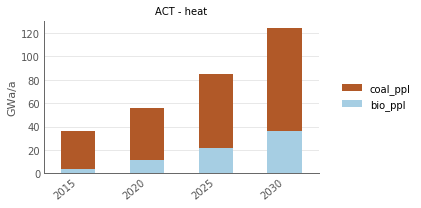

In [13]:
pp.barplot(df=df, filters={'technology': tecs, 'variable': ['ACT']},
           title='ACT - heat')

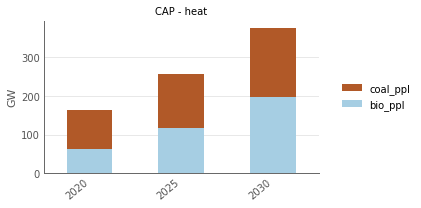

In [14]:
pp.barplot(df=df, filters={'technology': tecs, 'variable': ['CAP']},
           title='CAP - heat')

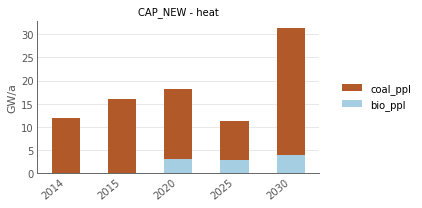

In [15]:
    pp.barplot(df=df, filters={'technology': tecs, 'variable': ['CAP_NEW']},
               title='CAP_NEW - heat')

# Workflow to get a scenario from data base and write all pars/sets to an excel sheet

In [16]:
# create an isntance of the ModifyModel class 
mod_model = ModifyModel(run_config='config/run_config.yml', model='MESSAGE_Indonesia', scen='Indonesia baseline',
                        xls_dir='input/scen2xls', file_name='data.xlsx', verbose=False)

2018-10-19 13:04:50,543  INFO d2ix.core - Load data base configurations
2018-10-19 13:04:50,544  INFO root - launching ixmp.Platform with local HSQLDB database at 'C:\Users\ga46gup\.local\ixmp\localdb\default'


In [17]:
# write the scenario to an excel workbook
mod_model.scen2xls(version=None)

2018-10-19 13:04:50,580  INFO d2ix.core - Load results for model: 'MESSAGE_Indonesia', scenario: 'Indonesia baseline', version: 'None' 
2018-10-19 13:04:50,911  INFO d2ix.core - Write model to excel


# Workflow to get a scenario from an excel sheet to the data base
The data in the excel sheet can now be mnodified and edited as required before beeing added to the database and solved in GAMS.  This can lead to **infeasibility** if non consistent changes are applied to the data no sanity checks are done to the data before beeing added to the data base.

In [18]:
# create an isntance of the ModifyModel class 
mod_model = ModifyModel(run_config='config/run_config.yml', model='MESSAGE_Indonesia', scen='Indonesia baseline',
                        xls_dir='input/scen2xls',
                        file_name='data.xlsx', verbose=False)

2018-10-19 13:04:51,749  INFO d2ix.core - Load data base configurations
2018-10-19 13:04:51,750  INFO root - launching ixmp.Platform with local HSQLDB database at 'C:\Users\ga46gup\.local\ixmp\localdb\default'


In [19]:
# write scenario from xlsx to data base and run the sceanrio in GAMS
mod_model.xls2model(annotation=None)
scenario = mod_model.model2db()
scenario.solve(model='MESSAGE')

2018-10-19 13:04:51,836  INFO d2ix.core - Create model from excel
2018-10-19 13:04:52,119  INFO d2ix.core - Prepare model input data
2018-10-19 13:04:52,203  INFO d2ix.core - Add sets to scenario
2018-10-19 13:04:52,212  INFO d2ix.core - Add parameter to scenario
2018-10-19 13:04:53,142  INFO d2ix.core - Write yaml output files
